In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

from statsmodels.graphics.gofplots import qqplot

# import statsmodels.api as sm

from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# def cles_ind(x1, x2):
#     """Calc common language effect size

#     Interpret as the probability that a score sampled
#     at random from one distribution will be greater than
#     a score sampled from some other distribution.

#     Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

#     :param x1: sample 1
#     :param x2: sample 2
#     :return: (float) common language effect size
#     """
#     x1 = np.array(x1)
#     x2 = np.array(x2)

#     diff = x1[:, None] - x2
#     cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

#     return cles

<IPython.core.display.Javascript object>

Data from: https://quickstats.nass.usda.gov/ with the following selections:
https://quickstats.nass.usda.gov/#D060E924-8D7D-33EB-ADE8-AB2D0DBA1862

CCD: HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DISORDER, MEASURED IN COLONIES

DEADOUT: HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED IN COLONIES

1. analyze the lost colonies for the goups with CCD or DEADOUT reasons
2. ??? analyze the lost colonies in the JAN THRU MAR period for 2019 and 2020 ????

In [4]:
df = pd.read_csv("data/raw_data.csv")
df.head(2)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2020,JAN THRU MAR,NaN,STATE,ALABAMA,1.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...",TOTAL,NOT SPECIFIED,70,NaN
1,SURVEY,2020,JAN THRU MAR,NaN,STATE,ALABAMA,1.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED ...",TOTAL,NOT SPECIFIED,410,NaN


<IPython.core.display.Javascript object>

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Program           458 non-null    object 
 1   Year              458 non-null    int64  
 2   Period            458 non-null    object 
 3   Week Ending       0 non-null      float64
 4   Geo Level         458 non-null    object 
 5   State             458 non-null    object 
 6   State ANSI        450 non-null    float64
 7   Ag District       0 non-null      float64
 8   Ag District Code  0 non-null      float64
 9   County            0 non-null      float64
 10  County ANSI       0 non-null      float64
 11  Zip Code          0 non-null      float64
 12  Region            0 non-null      float64
 13  watershed_code    458 non-null    int64  
 14  Watershed         0 non-null      float64
 15  Commodity         458 non-null    object 
 16  Data Item         458 non-null    object 
 1

<IPython.core.display.Javascript object>

In [5]:
df_clean = df.drop(
    [
        "Week Ending",
        "Ag District",
        "Ag District Code",
        "County",
        "County ANSI",
        "Zip Code",
        "Region",
        "watershed_code",
        "Watershed",
        "Commodity",
        "Domain",
        "Domain Category",
        "CV (%)",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [6]:
df_clean.head()

,Program,Year,Period,Geo Level,State,State ANSI,Data Item,Value
0,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...",70
1,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,"HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED ...",410
2,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...","4,300"
3,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,"HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED ...","6,500"
4,SURVEY,2020,JAN THRU MAR,STATE,ARKANSAS,5.0,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...",390


<IPython.core.display.Javascript object>

In [7]:
df_clean = df_clean.rename(
    columns={"Data Item": "Loss Reason", "Value": "Colonies Lost"}
)
df_clean.head()

,Program,Year,Period,Geo Level,State,State ANSI,Loss Reason,Colonies Lost
0,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...",70
1,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,"HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED ...",410
2,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...","4,300"
3,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,"HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED ...","6,500"
4,SURVEY,2020,JAN THRU MAR,STATE,ARKANSAS,5.0,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...",390


<IPython.core.display.Javascript object>

In [8]:
# df["prod_type"] = df["prod_type"].replace({"respon": "responsive", "r": "responsive"})
df_clean["Loss Reason"] = df_clean["Loss Reason"].replace(
    {
        "HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DISORDER, MEASURED IN COLONIES": "CCD",
        "HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED IN COLONIES": "DEADOUT",
    }
)
df_clean.head()

,Program,Year,Period,Geo Level,State,State ANSI,Loss Reason,Colonies Lost
0,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,CCD,70
1,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,DEADOUT,410
2,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,CCD,"4,300"
3,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,DEADOUT,"6,500"
4,SURVEY,2020,JAN THRU MAR,STATE,ARKANSAS,5.0,CCD,390


<IPython.core.display.Javascript object>

In [11]:
df_clean["Colonies Lost"] = df_clean["Colonies Lost"].str.replace(",", "")
df_clean.head()

,Program,Year,Period,Geo Level,State,State ANSI,Loss Reason,Colonies Lost
0,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,CCD,70
1,SURVEY,2020,JAN THRU MAR,STATE,ALABAMA,1.0,DEADOUT,410
2,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,CCD,4300
3,SURVEY,2020,JAN THRU MAR,STATE,ARIZONA,4.0,DEADOUT,6500
4,SURVEY,2020,JAN THRU MAR,STATE,ARKANSAS,5.0,CCD,390


<IPython.core.display.Javascript object>

In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Program        458 non-null    object 
 1   Year           458 non-null    int64  
 2   Period         458 non-null    object 
 3   Geo Level      458 non-null    object 
 4   State          458 non-null    object 
 5   State ANSI     450 non-null    float64
 6   Loss Reason    458 non-null    object 
 7   Colonies Lost  458 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 28.8+ KB


<IPython.core.display.Javascript object>

In [13]:
df_clean.describe()

,Year,State ANSI
count,458.000000,450.000000
mean,2019.397380,29.888889
std,0.489891,15.533887
min,2019.000000,1.000000
25%,2019.000000,18.000000
50%,2019.000000,29.000000
75%,2020.000000,42.000000
max,2020.000000,56.000000


<IPython.core.display.Javascript object>

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Program        458 non-null    object 
 1   Year           458 non-null    int64  
 2   Period         458 non-null    object 
 3   Geo Level      458 non-null    object 
 4   State          458 non-null    object 
 5   State ANSI     450 non-null    float64
 6   Loss Reason    458 non-null    object 
 7   Colonies Lost  458 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 28.8+ KB


<IPython.core.display.Javascript object>

In [15]:
df_clean["Colonies Lost"] = pd.to_numeric(df_clean["Colonies Lost"], errors="coerce")

<IPython.core.display.Javascript object>

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Program        458 non-null    object 
 1   Year           458 non-null    int64  
 2   Period         458 non-null    object 
 3   Geo Level      458 non-null    object 
 4   State          458 non-null    object 
 5   State ANSI     450 non-null    float64
 6   Loss Reason    458 non-null    object 
 7   Colonies Lost  458 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 28.8+ KB


<IPython.core.display.Javascript object>

In [17]:
df_clean["Loss Reason"].value_counts()

DEADOUT    230
CCD        228
Name: Loss Reason, dtype: int64

<IPython.core.display.Javascript object>

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Program        458 non-null    object 
 1   Year           458 non-null    int64  
 2   Period         458 non-null    object 
 3   Geo Level      458 non-null    object 
 4   State          458 non-null    object 
 5   State ANSI     450 non-null    float64
 6   Loss Reason    458 non-null    object 
 7   Colonies Lost  458 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 28.8+ KB


<IPython.core.display.Javascript object>

In [19]:
df_clean.groupby("Loss Reason").mean()

,Year,State ANSI,Colonies Lost
Loss Reason,,,
CCD,2019.394737,29.888889,1631.359649
DEADOUT,2019.400000,29.888889,8235.260870


<IPython.core.display.Javascript object>

In [20]:
df_clean.groupby("Loss Reason").median()

,Year,State ANSI,Colonies Lost
Loss Reason,,,
CCD,2019,29.0,425
DEADOUT,2019,29.0,1700


<IPython.core.display.Javascript object>

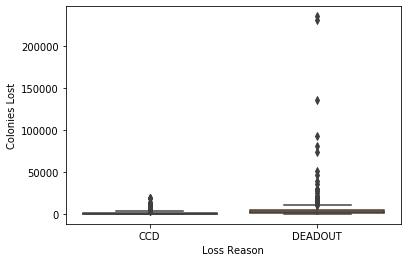

<IPython.core.display.Javascript object>

In [21]:
sns.boxplot(x="Loss Reason", y="Colonies Lost", data=df_clean)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

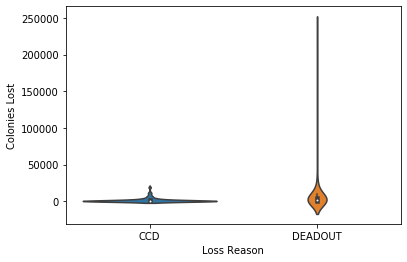

<IPython.core.display.Javascript object>

In [22]:
sns.violinplot(x="Loss Reason", y="Colonies Lost", data=df_clean)
plt.show

Bimodal distribution -- duh! 2 groups

In [23]:
ccd = df_clean[df_clean["Loss Reason"] == "CCD"]
deadout = df_clean[df_clean["Loss Reason"] == "DEADOUT"]

<IPython.core.display.Javascript object>

In [24]:
ccd.describe()

,Year,State ANSI,Colonies Lost
count,228.000000,225.000000,228.000000
mean,2019.394737,29.888889,1631.359649
std,0.489870,15.551215,3121.574830
min,2019.000000,1.000000,0.000000
25%,2019.000000,18.000000,130.000000
50%,2019.000000,29.000000,425.000000
75%,2020.000000,42.000000,1500.000000
max,2020.000000,56.000000,19500.000000


<IPython.core.display.Javascript object>

In [25]:
deadout.describe()

,Year,State ANSI,Colonies Lost
count,230.000000,225.000000,230.000000
mean,2019.400000,29.888889,8235.260870
std,0.490966,15.551215,25564.065231
min,2019.000000,1.000000,30.000000
25%,2019.000000,18.000000,812.500000
50%,2019.000000,29.000000,1700.000000
75%,2020.000000,42.000000,4875.000000
max,2020.000000,56.000000,235000.000000


<IPython.core.display.Javascript object>

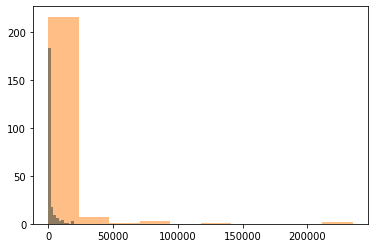

<IPython.core.display.Javascript object>

In [26]:
plt.hist(ccd["Colonies Lost"])
plt.hist(deadout["Colonies Lost"], alpha=0.5)
plt.show()

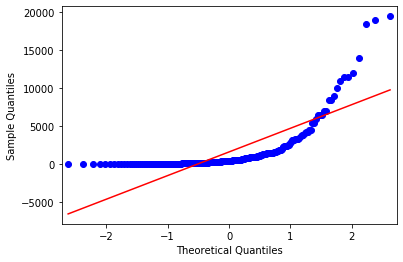

<IPython.core.display.Javascript object>

In [27]:
# quantile-quantile plot
qqplot(ccd["Colonies Lost"], line="s")
plt.show()

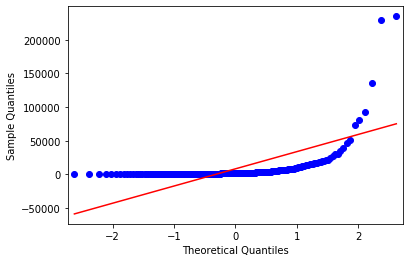

<IPython.core.display.Javascript object>

In [28]:
# quantile-quantile plot
qqplot(deadout["Colonies Lost"], line="s")
plt.show()

In [29]:
# Carrying out the Mann–Whitney test
_, p = stats.mannwhitneyu(ccd["Colonies Lost"], deadout["Colonies Lost"])
p


1.4555543281555452e-19

<IPython.core.display.Javascript object>

In [30]:
p < 0.05

True

<IPython.core.display.Javascript object>

There is a significant difference in median rank between the colonies lost due to Colony Colapse Disorder and the colonies lost due Deadout

The test shows that the colobnies loss due two the 2 reasons - ccd & deadout are statstically signigicant different.

Bootsrapped CI of median diff

In [32]:
median_diffs = []
for i in range(10000):
    s1 = ccd["Colonies Lost"].sample(frac=1.0, replace=True)
    s2 = deadout["Colonies Lost"].sample(frac=1.0, replace=True)

    median_diff = s1.median() - s2.median()
    median_diffs.append(median_diff)



ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)

ci_lo, ci_hi


(-1780.0, -990.0)

<IPython.core.display.Javascript object>

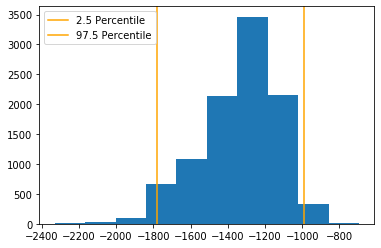

<IPython.core.display.Javascript object>

In [33]:
plt.hist(median_diffs)
plt.axvline(ci_lo, label="2.5 Percentile", c="orange")
plt.axvline(ci_hi, label="97.5 Percentile", c="orange")
plt.legend()
plt.show()

We are 95% confident that the typical number of colonies lost because of Deadout is 115 to 430 more than the number of colonies lost because of Colony Colapse Disorder

In [ ]:
df_clean["Year"].value_counts()

In [ ]:
df_clean["Period"].value_counts()

In [ ]:
df_clean.groupby(["Year", "Period"]).size()

In [ ]:
df_clean.groupby(["Year", "State"]).size()

In [ ]:
df_clean["State"].value_counts()

In [ ]:
df_clean.groupby(["Loss Reason", "Period"]).count()